### Install required packages

In [39]:
import sys

!pip install sentinelhub
!pip install basemap
!pip install mysql.connector

### Sentinel Hub Configuration

In [40]:
from IPython.display import display
import pandas as pd
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame
import pyrasterframes
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes.rasterfunctions import *
import pyrasterframes.rf_ipython
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame
from pyspark.sql.functions import udf, lit
from pyspark.sql.functions import col, year, weekofyear, month
from geomesa_pyspark.types import MultiPolygonUDT
# ML libraries
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

#sentinel hub 
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog
from sentinelhub import MimeType, CRS, BBox, Geometry,SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, geo_utils, bbox_to_dimensions, DownloadRequest, WmsRequest, WcsRequest, \
    filter_times,BBoxSplitter, OsmSplitter, TileSplitter, CustomGridSplitter, UtmZoneSplitter, UtmGridSplitter

INSTANCE_ID = '2a90b8d9-1b0a-43bc-9967-b86997723da9'
config = SHConfig()
config.instance_id = '2a90b8d9-1b0a-43bc-9967-b86997723da9'
config.sh_client_id = '25d75f9e-def7-4f5b-a99d-f011957d914b'
config.sh_client_secret = 'mr8?.Xn:G}tw24@fe2k%7G#Q%G,jajkgG)gBnKBD'

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from utils import plot_image #custom sentinel hub function , no use 
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import shape, Polygon, MultiPolygon, MultiLineString
from pyspark.sql.functions import lit
#for visualization purpose only
from matplotlib.patches import Polygon as plt_polygon
from mpl_toolkits.basemap import Basemap

#Database connection
import mysql.connector
import getpass

### Sentinel Hub WCS Request to get Satellite Image in Different Layers

In [47]:
def show_splitter(splitter, alpha=0.2, area_buffer=0.2, show_legend=False):
    try: 
        area_bbox = splitter.get_area_bbox()
        minx, miny, maxx, maxy = area_bbox
        lng, lat = area_bbox.middle
        w, h = maxx - minx, maxy - miny
        minx = minx - area_buffer * w
        miny = miny - area_buffer * h
        maxx = maxx + area_buffer * w
        maxy = maxy + area_buffer * h

        fig=plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)

        base_map = Basemap(projection='mill', lat_0=lat, lon_0=lng, llcrnrlon=minx, llcrnrlat=miny,
                           urcrnrlon=maxx, urcrnrlat=maxy, resolution='l', epsg=4326)
        base_map.drawcoastlines(color=(0, 0, 0, 0))

        area_shape = splitter.get_area_shape()

        if isinstance(area_shape, Polygon):
            polygon_iter = [area_shape]
        elif isinstance(area_shape, MultiPolygon):
            polygon_iter = area_shape.geoms
        else:
            raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

        for polygon in polygon_iter:
            if isinstance(polygon.boundary, MultiLineString):
                for linestring in polygon.boundary:
                    ax.add_patch(plt_polygon(np.array(linestring), closed=True, facecolor=(0, 0, 0, 0), edgecolor='red'))
            else:
                ax.add_patch(plt_polygon(np.array(polygon.boundary.coords), closed=True, facecolor=(0, 0, 0, 0), edgecolor='red'))

        bbox_list = splitter.get_bbox_list()
        info_list = splitter.get_info_list()

        cm = plt.get_cmap('jet', len(bbox_list))
        legend_shapes = []
        for i, (bbox, info) in enumerate(zip(bbox_list, info_list)):
            wgs84_bbox = bbox.transform(CRS.WGS84).get_polygon()

            tile_color = tuple(list(cm(i))[:3] + [alpha])
            ax.add_patch(plt_polygon(np.array(wgs84_bbox), closed=True, facecolor=tile_color, edgecolor='green'))

            if show_legend:
                legend_shapes.append(plt.Rectangle((0,0),1,1, fc=cm(i)))

        if show_legend:
            legend_names = []
            for info in info_list:
                legend_name = '{},{}'.format(info['index_x'], info['index_y'])

                for prop in ['grid_index', 'tile']:
                    if prop in info:
                        legend_name = '{},{}'.format(info[prop], legend_name)

                legend_names.append(legend_name)

            plt.legend(legend_shapes, legend_names)
        plt.tight_layout()
        plt.show()
    except Exception as e: 
        print(e)

In [48]:
ndvi_tiff_ids=[]
ndwi_tiff_ids=[]
moist_tiff_ids=[]
date_list=[]
list_of_df=[]
ndvi_tiff_list=[]
moist_tiff_list=[]
ndwi_tiff_list=[]

# This job is more memory bound, so reduce the concurrent tasks.
def create_spark_session():
    spark = create_rf_spark_session("local[4]")
    return spark 

def split_area(area) :
    try:
        global bbox_list
        url='https://nominatim.openstreetmap.org/search.php?state={}&polygon_geojson=1&format=json'.format(area)
        r =requests.get(url)
        response = json.loads(r.text)
        for coordinate in response:
            [temp_cor] = coordinate['geojson']['coordinates']
        poly = Polygon(temp_cor)                      
        bbox_splitter_reduced = BBoxSplitter([poly], CRS.WGS84,(5,5), reduce_bbox_sizes=True)
        # Get a list of bboxes from the splitter
        bbox_list = bbox_splitter_reduced.get_bbox_list()
        print('total bbox generated is {}'.format(len(bbox_list)))
        show_splitter(bbox_splitter_reduced)
    except Exception as e: 
        print(e)
    
# provide splitted betsiboka_bbox from the 
def get_data_from_sentinel(betsiboka_bbox,area='',month=''): 
    try:
        global saved_data_dir,dates,ndvi_tiff_ids,moist_tiff_ids,ndwi_tiff_ids,total_file_length,current_file_length,id_ndvi,id_ndwi,id_moist,date_list
        my_data_collection = DataCollection.SENTINEL2_L2A
        saved_data_dir = 'image_test/'
        my_resX = '20m'
        my_rexY = '20m'
        time_interval = ('2018-{}-01'.format(month), '2018-{}-30'.format(month))
        saved_data_path = saved_data_dir+area+"/"+month

        # NDVI
        wcs_ndvi_request= WcsRequest(
            data_collection=my_data_collection,
            data_folder=saved_data_path,
            layer='NDVI',
            bbox=betsiboka_bbox,
            time=time_interval,
            image_format=MimeType.TIFF,
            resx= my_resX,
            resy= my_rexY,
            config=config
        )


        wcs_ndvi_request.get_data(save_data=True)
        id_ndvi=wcs_ndvi_request.get_filename_list()
        dates=wcs_ndvi_request.get_dates()

        # NDMI
        wcs_moisture_request= WcsRequest(
            data_collection=my_data_collection,
            data_folder=saved_data_path,
            layer='MOISTURE-INDEX',
            bbox=betsiboka_bbox,
            time=time_interval,
            image_format=MimeType.TIFF,
            resx=my_resX,
            resy=my_rexY,
            config=config
        )

        wcs_moisture_request.get_data(save_data=True)
        id_moist=wcs_moisture_request.get_filename_list()


        # NDWI
        wcs_ndwi_request= WcsRequest(
            data_collection=my_data_collection,
            data_folder=saved_data_path,
            layer='NDWI',
            bbox=betsiboka_bbox,
            time=time_interval,
            image_format=MimeType.TIFF,
            resx=my_resX,
            resy=my_rexY,
            config=config
        )

        wcs_ndwi_request.get_data(save_data=True)
        id_ndwi=wcs_ndwi_request.get_filename_list()
    except Exception as e: 
        print(e)
    
    
def request_image_per_bbox(area,month) :
    try:
        for bbox_index in range(len(bbox_list)) :
            betsiboka_bbox=bbox_list[bbox_index]
            get_data_from_sentinel(betsiboka_bbox,area,month)
            ndvi_tiff_ids.extend(id_ndvi)
            ndwi_tiff_ids.extend(id_ndwi)
            moist_tiff_ids.extend(id_moist)
            date_list.extend(dates)    
            print('Downloaded {} images...'.format(len(ndvi_tiff_ids)))
        
        print('Download Completed')
        print('Total tiff file downloaded for each band:' , len(ndvi_tiff_ids))
    except Exception as e: 
        print(e)
        
def build_file_path(area,month): 
    try: 
        spark = create_spark_session()
        tiff_length = len(ndvi_tiff_ids)
        for x in range(tiff_length) :
            base = saved_data_dir + area + '/' + month + '/'
            ndvi_tiff_list.append(base + ndvi_tiff_ids[x])
            moist_tiff_list.append(base + moist_tiff_ids[x])
            ndwi_tiff_list.append(base + ndwi_tiff_ids[x])

        columns = ['NDVI','MOISTURE_INDEX','NDWI','ACQUISITION_TIMESTAMP']
        df = spark.createDataFrame(zip(ndvi_tiff_list,moist_tiff_list,ndwi_tiff_list,date_list), columns)
        df_area=df.withColumn("AREA",lit(area)) #lit func create a constant column 
        df_area.show()
        list_of_df.append(df_area)
        print('Spark dataframe for {} created.'.format(area))
        return list_of_df
    except Exception as e: 
        print(e)

### Download Image

In [49]:
def get_area_img_by_month(month): 
    try:
        eswatini_areas = ['Hhohho','Manzini','Lubombo','Shiselweni']
        for area in eswatini_areas :
            split_area(area)
            request_image_per_bbox(area,month)
            build_file_path(area,month)
            all_list=[dates,ndvi_tiff_ids,moist_tiff_ids,ndwi_tiff_ids,id_ndvi,id_ndwi,id_moist,date_list,ndvi_tiff_list,moist_tiff_list,ndwi_tiff_list]
            for x in all_list :
                x.clear()
        print("Image for month {} downloaded for all 4 area.".format(month))
    except Exception as e: 
        print(e)

total bbox generated is 20


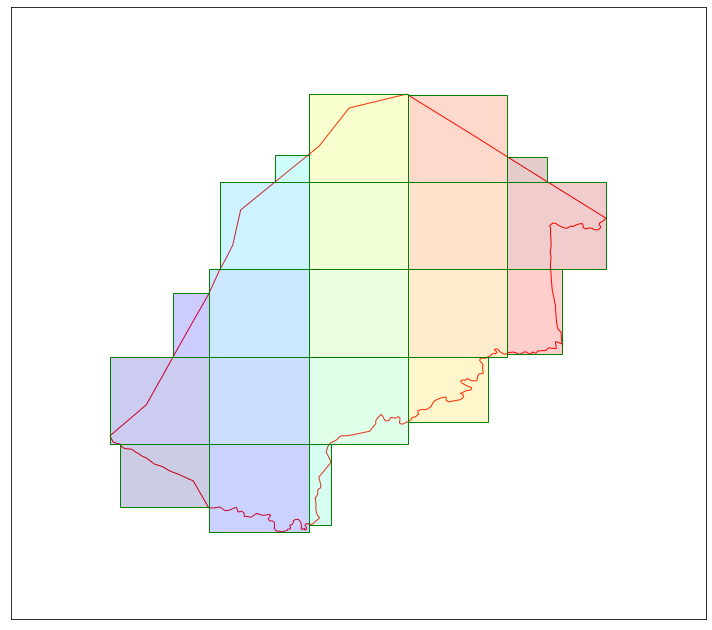

Downloaded 6 images...
Downloaded 12 images...
Downloaded 18 images...
Downloaded 24 images...
Downloaded 30 images...
Downloaded 36 images...
Downloaded 42 images...
Downloaded 48 images...
Downloaded 54 images...
Downloaded 60 images...
Downloaded 66 images...
Downloaded 72 images...
Downloaded 78 images...
Downloaded 84 images...
Downloaded 90 images...
Downloaded 96 images...
Downloaded 102 images...
Downloaded 108 images...
Downloaded 114 images...
Downloaded 120 images...
Download Completed
Total tiff file downloaded for each band: 120
+--------------------+--------------------+--------------------+---------------------+------+
|                NDVI|      MOISTURE_INDEX|                NDWI|ACQUISITION_TIMESTAMP|  AREA|
+--------------------+--------------------+--------------------+---------------------+------+
|image_test/Hhohho...|image_test/Hhohho...|image_test/Hhohho...|  2018-07-03 08:04:03|Hhohho|
|image_test/Hhohho...|image_test/Hhohho...|image_test/Hhohho...|  2018-07-08

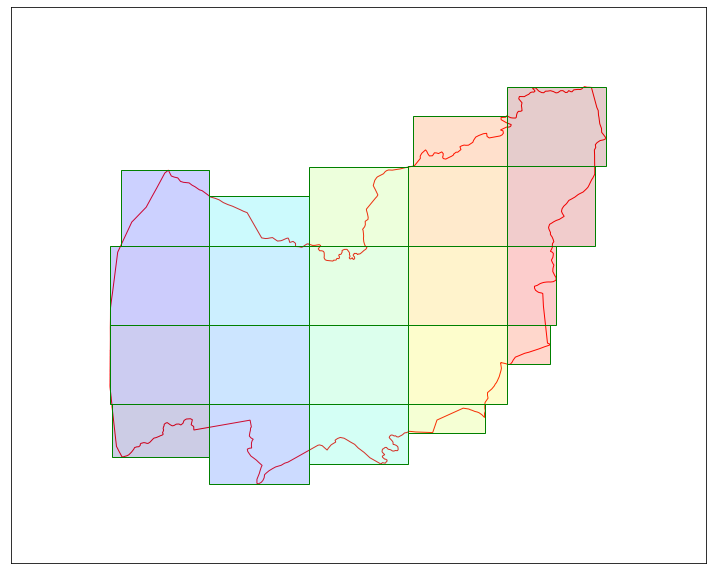

Downloaded 6 images...
Downloaded 12 images...
Downloaded 18 images...
Downloaded 24 images...
Downloaded 30 images...
Downloaded 36 images...
Downloaded 42 images...
Downloaded 48 images...
Downloaded 54 images...
Downloaded 60 images...
Downloaded 66 images...
Downloaded 72 images...
Downloaded 78 images...
Downloaded 84 images...
Downloaded 90 images...
Downloaded 96 images...
Downloaded 102 images...
Downloaded 108 images...
Downloaded 114 images...
Downloaded 120 images...
Downloaded 126 images...
Download Completed
Total tiff file downloaded for each band: 126
+--------------------+--------------------+--------------------+---------------------+-------+
|                NDVI|      MOISTURE_INDEX|                NDWI|ACQUISITION_TIMESTAMP|   AREA|
+--------------------+--------------------+--------------------+---------------------+-------+
|image_test/Manzin...|image_test/Manzin...|image_test/Manzin...|  2018-07-03 08:04:03|Manzini|
|image_test/Manzin...|image_test/Manzin...|imag

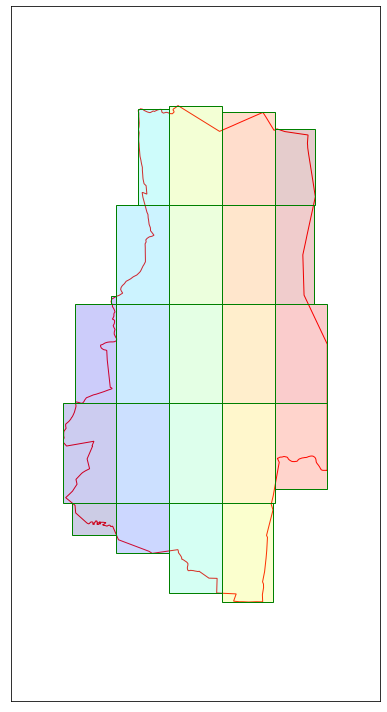

Downloaded 6 images...
Downloaded 12 images...
Downloaded 18 images...
Downloaded 24 images...
Downloaded 30 images...
Downloaded 36 images...
Downloaded 42 images...
Downloaded 48 images...
Downloaded 54 images...
Downloaded 60 images...
Downloaded 66 images...
Downloaded 72 images...
Downloaded 78 images...
Downloaded 84 images...
Downloaded 90 images...
Downloaded 96 images...
Downloaded 102 images...
Downloaded 108 images...
Downloaded 114 images...
Downloaded 120 images...
Downloaded 126 images...
Downloaded 132 images...
Downloaded 138 images...
Download Completed
Total tiff file downloaded for each band: 138
+--------------------+--------------------+--------------------+---------------------+-------+
|                NDVI|      MOISTURE_INDEX|                NDWI|ACQUISITION_TIMESTAMP|   AREA|
+--------------------+--------------------+--------------------+---------------------+-------+
|image_test/Lubomb...|image_test/Lubomb...|image_test/Lubomb...|  2018-07-03 08:04:03|Lubomb

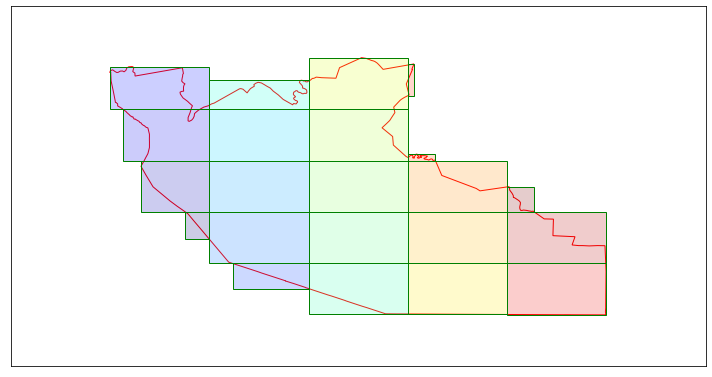

Downloaded 6 images...
Downloaded 12 images...
Downloaded 18 images...
Downloaded 24 images...
Downloaded 30 images...
Downloaded 36 images...
Downloaded 42 images...
Downloaded 48 images...
Downloaded 54 images...
Downloaded 60 images...
Downloaded 66 images...
Downloaded 72 images...
Downloaded 78 images...
Downloaded 84 images...
Downloaded 90 images...
Downloaded 96 images...
Downloaded 102 images...
Downloaded 108 images...
Downloaded 114 images...
Downloaded 120 images...
Downloaded 126 images...
Downloaded 132 images...
Download Completed
Total tiff file downloaded for each band: 132
+--------------------+--------------------+--------------------+---------------------+----------+
|                NDVI|      MOISTURE_INDEX|                NDWI|ACQUISITION_TIMESTAMP|      AREA|
+--------------------+--------------------+--------------------+---------------------+----------+
|image_test/Shisel...|image_test/Shisel...|image_test/Shisel...|  2018-07-03 08:04:03|Shiselweni|
|image_tes

In [50]:
#get 2018 data 
get_area_img_by_month('6')
get_area_img_by_month('7')
get_area_img_by_month('8')
get_area_img_by_month('9')
get_area_img_by_month('10')
get_area_img_by_month('11')
get_area_img_by_month('12')

### Combines Images with Their Acquisition Time Stamp

In [69]:
def UnionAllDF():
    try:
        raster_df = reduce(DataFrame.unionAll, list_of_df) 
        return raster_df 
    except Exception as e: 
        print(e)

In [79]:
def readRaster(): 
    try:
        spark = create_spark_session()
        raster_df = UnionAllDF()
        rf= spark.read.raster(raster_df,catalog_col_names=['NDVI','MOISTURE_INDEX','NDWI'])#The catalog_col_names parameter gives the columns that contain the raster source to be read.
        return rf
    except Exception as e: 
        print(e)
        
def agg_raster(): 
    try:
        rf=readRaster()
        raster_agg_df = rf \
                .groupby(
                    'ACQUISITION_TIMESTAMP',
                    'AREA',
                    weekofyear('ACQUISITION_TIMESTAMP').alias('week'),
                    month('ACQUISITION_TIMESTAMP').alias('month')) \
                .agg(rf_agg_mean('NDVI').alias('NDVI_AGG'),\
                     rf_agg_mean('NDWI').alias('NDWI_AGG'),\
                     rf_agg_mean('MOISTURE_INDEX').alias('MOIST_AGG'))
        return raster_agg_df
    except Exception as e: 
        print(e)

### Data Preprocessing

In [132]:
def merge_df():
    try:
        spark=create_spark_session()
        raster_agg_df=agg_raster()
        ipc_df=spark.read.option('header',True).csv('Merged_IPC.csv') # merged labeled data
        conditions = [raster_agg_df.AREA == ipc_df.area_ipc,raster_agg_df.month == ipc_df.analysis_month]
        famine_df=raster_agg_df.join(ipc_df,conditions,"fullouter")
        famine_df=famine_df.drop('area_ipc','analysis_date','analysis_month')
        famine_df=famine_df.na.drop()
        famine_df.toPandas().to_csv('famine_dataset.csv',index=False)
        famine_df=pd.read_csv('famine_dataset.csv')
        
        db_connection = mysql.connector.connect(host = 'host.docker.internal',port = 3306, user = 'root', db = 'mysql')
        # create and use a new database/schema TestDB
        db_cursor = db_connection.cursor()
        #run one time only 
        db_cursor.execute("DROP DATABASE IF EXISTS satietydb")
        db_cursor.execute("CREATE DATABASE SatietyDB;")
        #Creating table as per requirement
        sql ='''CREATE TABLE famine(
           ACQUISITION_TIMESTAMP VARCHAR(50) NOT NULL,
           AREA VARCHAR(50) NOT NULL,
           WEEK INT,
           MONTH INT,
           NDVI_AGG DOUBLE,
           NDWI_AGG DOUBLE,
           MOIST_AGG DOUBLE,
           OVERALL_PHASE INT
        )'''
        db_cursor.execute("USE satietydb;")
        db_cursor.execute("DROP TABLE IF EXISTS famine")
        db_cursor.execute(sql)
        #loop through the data frame
        for i,row in famine_df.iterrows():
            #here %S means string values 
            sql = "INSERT INTO famine VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"
            db_cursor.execute(sql, tuple(row))
            print("Record inserted")
            # the connection is not auto committed by default, so we must commit to save our changes
            db_connection.commit()
        return famine_df
    except Exception as e: 
        print(e)

### Machine Learning

In [139]:
def select_features():
    try:
        df_ml = merge_df() #load data
        feature_cols = ['NDVI_AGG', 'NDWI_AGG', 'MOIST_AGG']
        X = df_ml[feature_cols] # Features
        y = df_ml['overall_phase']# Target variable
        return X, y
    except Exception as e: 
        print(e)  

In [145]:
def split_data():
    try:
        X, y = select_features()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test
        return X_train, X_test, y_train, y_test
    except Exception as e: 
        print(e)

In [146]:
def DecisionTree_Forecast():
    try:
        X_train, X_test, y_train, y_test = split_data()
        # Create Decision Tree classifer object
        model = DecisionTreeClassifier(criterion="entropy")

        # Train Decision Tree Classifer
        model.fit(X_train,y_train)

        #Predict the response for test dataset
        y_pred = model.predict(X_test)

        # Evaluate Model
        print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    except Exception as e: 
        print(e)      